In [2]:
# importamos librerías necesarias pytorch, numpy y PIL
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms

import time
import os
import copy

import numpy as np
from PIL import Image

In [3]:
# Source - https://stackoverflow.com/a
# Posted by user4720834
# Retrieved 2025-12-16, License - CC BY-SA 3.0

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Datasets and DataLoaders

- Dataset is a Python class that aloows you to get the data you're supllying to the neural network
- DataLoader feeds data from the dataset into the network


# Get datat into the Model

- Read the pictures, meaning JPEG Files
- Decode the JPEG files to RGB grids of pixels
- Convert there into floating-point tensors
- Resize hem to a shared size
- Pack them into batches (of four images)

In [4]:
data_dir = 'd:\\Curso\\jupiter\\2025-ML-Zoomcamp\\Week8-pytorch\\data\\muffin'

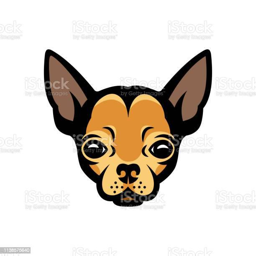

In [5]:
img = Image.open(f'{data_dir}/train/chihuahua/img_0_0.jpg')
img.resize((256, 256))

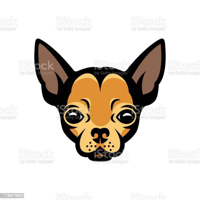

In [6]:
img.resize((200,200))

In [7]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic= True
torch.backends.cudnn.benchmark= False
cudnn.benchmark = True

In [8]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [9]:
# transform images
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [15]:
# create image folders for our training and validation data
folders = ['train', 'test']

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in folders}

# get dataset sizes from image_datasets
dataset_sizes = {x: len(image_datasets[x]) for x in folders}

# get class_names from image_datasets
class_names = image_datasets['train'].classes

# use image_datasets to sample from the dataset
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True)
              for x in folders}

In [17]:
def imshow(inp, title=None):

    # transpose is required to get the images into the correct shape
    inp = inp.numpy().transpose((1, 2, 0))

    # use default values for mean and std
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # visualize the correct colors
    inp = std * inp + mean

    # view a clipped version of an image
    inp = np.clip(inp, 0, 1)

    # visualize inp
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [63]:
# get a batch of training data
inputs, classes = next(iter(dataloaders['test']))
print(inputs,classes)

tensor([[[[ 1.3070,  1.3755,  1.4440,  ...,  1.0331,  1.0331,  1.0673],
          [ 1.2899,  1.4440,  1.4783,  ...,  1.0673,  1.0673,  1.0502],
          [ 1.2728,  1.4440,  1.5639,  ...,  0.9817,  0.9474,  0.9988],
          ...,
          [-2.0837, -2.1008, -2.0665,  ..., -1.3815, -1.3987, -1.3815],
          [-2.0837, -2.0837, -2.0837,  ..., -1.3987, -1.4158, -1.4158],
          [-2.1008, -2.0837, -2.0837,  ..., -1.3987, -1.3815, -1.3987]],

         [[ 1.2206,  1.2381,  1.3081,  ...,  1.1681,  1.1506,  1.1155],
          [ 1.2031,  1.3081,  1.3431,  ...,  1.1681,  1.1331,  1.1155],
          [ 1.1681,  1.3256,  1.4307,  ...,  1.1681,  1.1506,  1.1155],
          ...,
          [-2.0007, -1.9832, -1.9482,  ..., -1.5105, -1.5280, -1.5105],
          [-1.9832, -1.9657, -1.9657,  ..., -1.5455, -1.5455, -1.5105],
          [-1.9832, -1.9832, -1.9832,  ..., -1.5630, -1.5455, -1.5105]],

         [[ 1.2980,  1.3677,  1.4374,  ...,  1.2457,  1.2457,  1.2108],
          [ 1.2980,  1.4200,  

In [64]:
# make a grid from batch
out = torchvision.utils.make_grid(inputs)

print(out)

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  1.3070,  ...,  2.2318,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000, -2.1008,  ..., -0.7650,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  1.2206,  ...,  2.4111,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000, -1.9832,  ..., -0.7752,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0

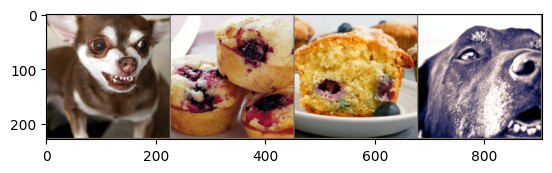

In [ ]:
# plot the grid with a title that concatenates all the class labels
imshow(
    out
    #,title=[class_names[x] for x in classes]
    )

In [119]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=8):

    since = time.time()

    # create a deep copy of the model provided
    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # iterate over data using the dataloader we defined
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward pass and optimization only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # computing loss statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # create a deep copy of the model

            if phase == 'test' and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # for formatting
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_accuracy:4f}')

    # load the best model weights
    model.load_state_dict(best_model_wts)
    return model
     

In [10]:
def visualize_model(model, num_images=6):

    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            print("Outputs: ",_)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                print("J: ",j,preds,preds[j],class_names)
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [72]:
model_ft = models.resnet18(weights=True) ## loaded our model

num_ftrs = model_ft.fc.in_features

# move model to device
model_ft = model_ft.to(device)

# define loss function
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


c:\Users\ITPB-RH\.conda\envs\dev\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [120]:
# call our train_model() function with the ResNet model, the criterion, optimizer, learning rate scheduler, and number of epochs that we have defined.
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=8)
 

Epoch 0/7
----------
train Loss: 2.0832 Acc: 0.6497
test Loss: 0.6376 Acc: 0.8590

Epoch 1/7
----------
train Loss: 0.3945 Acc: 0.8720
test Loss: 0.2697 Acc: 0.9333

Epoch 2/7
----------
train Loss: 0.3401 Acc: 0.8745
test Loss: 0.2262 Acc: 0.9443

Epoch 3/7
----------
train Loss: 0.3097 Acc: 0.8804
test Loss: 0.2163 Acc: 0.9502

Epoch 4/7
----------
train Loss: 0.3112 Acc: 0.8783
test Loss: 0.1888 Acc: 0.9535

Epoch 5/7
----------
train Loss: 0.2755 Acc: 0.8918
test Loss: 0.1495 Acc: 0.9628

Epoch 6/7
----------
train Loss: 0.2742 Acc: 0.8963
test Loss: 0.1595 Acc: 0.9628

Epoch 7/7
----------
train Loss: 0.2632 Acc: 0.8980
test Loss: 0.1700 Acc: 0.9586

Training complete in 28m 12s
Best val Acc: 0.962838


In [121]:
torch.save(model_ft, "model/model_ft.pth")

In [12]:
model_ft_load = torch.load("model/model_ft.pth",weights_only=False)

In [123]:
torch.save(model_ft.state_dict(), "model/model_ft_sec")

In [13]:
model_ft_state_dict = torch.load("model/model_ft_sec")
model_ft_load.load_state_dict(model_ft_state_dict)

<All keys matched successfully>

Outputs:  tensor([15.1158, 15.3299, 15.2242, 17.7888], device='cuda:0')
J:  0 tensor([  1,   1, 937,   1], device='cuda:0') tensor(1, device='cuda:0') ['chihuahua', 'muffin']


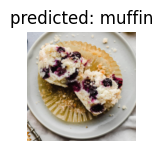

J:  1 tensor([  1,   1, 937,   1], device='cuda:0') tensor(1, device='cuda:0') ['chihuahua', 'muffin']


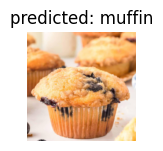

J:  2 tensor([  1,   1, 937,   1], device='cuda:0') tensor(937, device='cuda:0') ['chihuahua', 'muffin']


IndexError: list index out of range

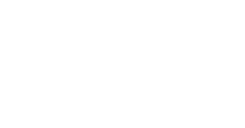

In [18]:
# visualize model
visualize_model(model_ft_load)
plt.show()